<a href="https://colab.research.google.com/github/G0nkly/pytorch_sandbox/blob/main/gpts/DIY_AK_GPT2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
##
# LETS DO THE FOLLOWING
# TASK I:
# - download https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
# - load the downloaded data, create a vocab and a tokenization
# - split the dataset into train and test and move it into the pytorch "world"
# - create a get_batch(split) function
# - create a estimate_loss() function (for the loss on train and test)
# - create a Bigram model with a forward(self, x, targets) and generate(self, idx, max_new_tokens) function
# - create a train loop (with evaluation) and extract all hyperparameters into a separate space
# - use the model on some example input
# - common pitfalls: torch device, # of parameters, train loop + eval
#
# TASK II:
# - Create a new model from the Bigram Model and add the following
# -- Positional Encoding
# -- A single attention head
# -- Multiple Attention Heads in parallel
# -- A FeedForward Layer
# -- LayerNormas and Residual Connections


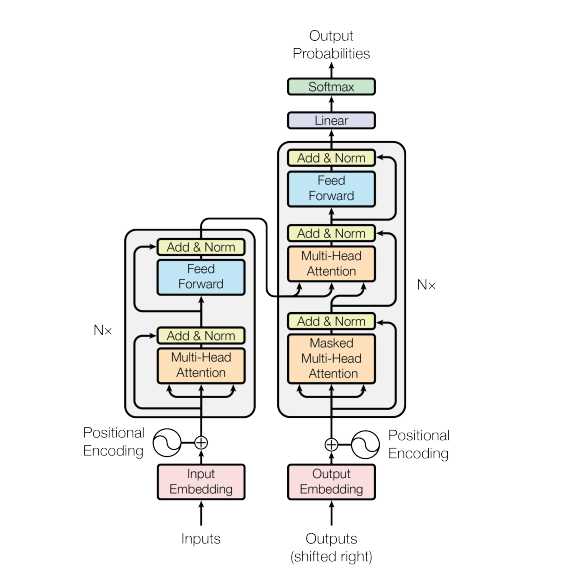

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [24]:
#####################
# DATASET RETRIEVAL #
#####################

In [25]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2025-10-05 02:53:48--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.1’

input.txt.1         100%[===================>]   1.06M  --.-KB/s    in 0.03s   

2025-10-05 02:53:48 (34.1 MB/s) - ‘input.txt.1’ saved [1115394/1115394]



In [26]:
with open("input.txt", mode="r") as f:
  text = f.read()

print(text[:10])

First Citi


In [27]:
###################
# HYPERPARAMETERS #
###################

In [28]:
block_size = 8
batch_size = 32
device = "cuda" if torch.cuda.is_available() else "cpu"
embed_dim = 32
n_epochs = 10
learning_rate = 1e-04
test_epochs = 200
eval_iters = 100

In [29]:
###############################
# TOKENIZATION AND DATALOADER #
###############################

In [30]:
vocab = list(sorted(set(text)))
text_to_num = {v:k for k,v in enumerate(vocab)}
num_to_text = {k:v for k,v in enumerate(vocab)}
vocab_size = len(vocab)

In [31]:
encode = lambda text: [text_to_num[t] for t in text]
decode = lambda numbers: "".join([num_to_text[n] for n in numbers])

In [32]:
decode(encode("Haubi"))

'Haubi'

In [33]:
data = torch.tensor(encode(text))
train_idx = int(0.9 * len(data))
train = data[:train_idx]
test = data[train_idx:]
len(train), len(test)

(1003854, 111540)

In [34]:
def get_batch(split):
  dataset = train if split == "train" else test
  idx = torch.randint(0, len(train) - block_size, (batch_size,))
  X = torch.stack([train[i:i +  block_size] for i in idx])
  Y = torch.stack([train[i + 1: i + block_size + 1] for i in idx])
  X, Y = X.to(device), Y.to(device)

  return X, Y

In [35]:
X, Y = get_batch("train")
X[1], Y[1]

(tensor([57,  1, 42, 47, 60, 47, 42, 43]),
 tensor([ 1, 42, 47, 60, 47, 42, 43, 42]))

In [36]:
@torch.no_grad()
def evaluate_model(model):
  out = {}
  model.eval()
  for split in ["train", "test"]:
    test_loss = torch.zeros(test_epochs)
    for epch in range(test_epochs):
      Xtst_b, Ytst_b = get_batch("test")
      _, loss = model(Xtst_b, Ytst_b)

      test_loss[epch] = loss.item()

    out[split] = test_loss.mean(dim=-1)

  model.train()

  return out

In [37]:
################
# BUILD MODELS #
################

In [38]:
class SimpleBiGramModel(nn.Module):

  def __init__(self):
    super().__init__()
    self.emb = nn.Embedding(vocab_size, vocab_size)

  def forward(self, x, targets=None):
    logits = self.emb(x)
    if targets is not None:
      B, T, C = logits.shape
      logits = logits.view(B*T, C)
      targets = targets.view(B*T)
      loss = F.cross_entropy(logits, targets)
      return logits, loss
    return logits

  def generate(self, start_token, length):
    """
    start_token: (B, 1) tensor with the initial token(s)
    length: how many new tokens to generate
    """
    for _ in range(length):
      # only keep the last token
      input = start_token[:, -block_size:]   # shape (B, 1)

      # forward pass → logits for vocab
      logits = self(input)          # (B, 1, C)

      # take the logits at the last position
      print(logits)
      logits = logits[:, -1, :]     # (B, C)

      # turn into probabilities
      probs = F.softmax(logits, dim=-1)  # (B, C)

      # sample next token for each batch
      next_token = torch.multinomial(probs, num_samples=1)  # (B, 1)

      # append to sequence
      start_token = torch.cat((start_token, next_token), dim=1)

    return start_token


In [41]:
class MyBelovedTransformer(nn.Module):

  def __init__(self):
    super().___init__()
    self.tok_embd = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim)

  def forward(self, x, targets=None):
    x = self.tok_embd(x) # B, T, C
    if targets is None:
      loss = None
    else:
      B, T, C = x.shape
      x = x.view(B*T, -1) # B*T, C
      targets = targets.view(B*T) # B*T
      loss = F.cross_entropy(x, targets)

    return x, loss

In [ ]:
model = SimpleBiGramModel()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(1000):

  if epoch % eval_iters == 0 or epoch == n_epochs - 1:
    out = evaluate_model(model)
    print(f"Epoch: {epoch}, train loss: {out["train"]:.4f}, test loss: {out["test"]:.4f}")

  X_batch, Y_batch = get_batch("train")
  logits, loss = model(X_batch, Y_batch)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  X_test_batch, Y_test_batch = get_batch("test")
  _, test_loss = model(X_test_batch, Y_test_batch)



Epoch: 0, train loss: 4.6893, test loss: 4.7000
Epoch: 9, train loss: 4.6976, test loss: 4.7044
Epoch: 100, train loss: 4.6996, test loss: 4.6925
Epoch: 200, train loss: 4.6772, test loss: 4.6847
Epoch: 300, train loss: 4.6682, test loss: 4.6689
Epoch: 400, train loss: 4.6481, test loss: 4.6577
Epoch: 500, train loss: 4.6444, test loss: 4.6420
Epoch: 600, train loss: 4.6307, test loss: 4.6319
Epoch: 700, train loss: 4.6203, test loss: 4.6171
Epoch: 800, train loss: 4.6224, test loss: 4.6042
Epoch: 900, train loss: 4.5891, test loss: 4.5963


In [ ]:
generated_output = model.generate(torch.randint(0, 65, (1, 8)), 30)
output_list = generated_output.view(-1).tolist()
"".join([decode(output_list)])

tensor([[[-1.3860, -1.0110,  1.5848,  0.7454,  1.2301,  0.1748,  0.5405,
          -0.0203,  0.9286,  1.2843,  0.4494,  0.0581,  0.7455, -0.2850,
          -0.9025, -1.3382, -1.3713, -1.2362,  0.0349,  0.7010, -0.9698,
          -0.2489, -0.9795, -1.8778, -0.0361,  0.3200,  0.9588, -1.0801,
           0.2257,  0.0660,  1.4187, -0.4797,  0.9588, -1.5250, -1.6125,
          -1.0485,  0.0296, -0.0130, -1.0116, -0.6900, -1.0708, -0.0780,
           0.8707,  1.3408,  1.3981, -0.3270,  1.1581,  0.1988, -0.2283,
          -0.1103, -0.5558,  0.7458, -0.9032, -1.3613,  0.8578, -0.3755,
           0.4117, -1.0287, -0.7225,  0.8521, -1.9156, -0.7152,  0.6085,
           0.1582,  0.0564],
         [ 0.7296, -0.2901, -0.1453,  1.5651, -0.2909,  0.6255, -0.5584,
           1.5270, -0.1938,  0.0872,  0.7594, -0.1921, -0.1148, -0.5861,
           1.1749, -0.8271,  1.0367, -0.3628,  0.4927,  1.5642,  0.0841,
          -0.1449, -1.1164,  0.0456, -0.6420,  0.3842,  1.2448,  1.5266,
           0.1498, -0.

'otZmWgeKfMwyEhd$CH:nEnN,jJsA;&m,W;DwWK'